In [1]:
import bottlenecking as btl
import tensorflow as tf
import numpy as np
import pandas as pd
import uns
from uns import training
from fcn_model import fcn16_vgg
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

In [2]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.InteractiveSession(config=config)

In [3]:
sess = tf.InteractiveSession()

In [4]:
batch_images = tf.placeholder(tf.float32,[None, 416, 576, 3])
#batch_masks = tf.placeholder(tf.float32, [None, 420, 580, 2])  #Size 2 => "yes" and "no"

In [5]:
vgg_path = '../vgg16.npy'

In [6]:
net = fcn16_vgg.FCN16VGG(vgg16_npy_path=vgg_path)

npy file loaded


In [7]:
with tf.name_scope("content_vgg"):
       net.build(batch_images, train=False, num_classes=2, random_init_fc8=True,debug=False)

Layer name: conv1_1
Layer shape: (3, 3, 3, 64)
Layer name: conv1_2
Layer shape: (3, 3, 64, 64)
Layer name: conv2_1
Layer shape: (3, 3, 64, 128)
Layer name: conv2_2
Layer shape: (3, 3, 128, 128)
Layer name: conv3_1
Layer shape: (3, 3, 128, 256)
Layer name: conv3_2
Layer shape: (3, 3, 256, 256)
Layer name: conv3_3
Layer shape: (3, 3, 256, 256)
Layer name: conv4_1
Layer shape: (3, 3, 256, 512)
Layer name: conv4_2
Layer shape: (3, 3, 512, 512)
Layer name: conv4_3
Layer shape: (3, 3, 512, 512)
Layer name: conv5_1
Layer shape: (3, 3, 512, 512)
Layer name: conv5_2
Layer shape: (3, 3, 512, 512)
Layer name: conv5_3
Layer shape: (3, 3, 512, 512)
Layer name: fc6
Layer shape: [7, 7, 512, 4096]
Layer name: fc7
Layer shape: [1, 1, 4096, 4096]


In [8]:
bottleneck=[net.fc6, net.pool4]

In [9]:
btl.get_bottleneck_dims(bottleneck[0])

[13, 18, 4096]

In [10]:
def build_batch_output_w_masks(imgs,masks,path,bottlenecks,sess):
    """writes a single batch to disk"""    
    batch_size = imgs.shape[0]   
    bottles = sess.run(bottlenecks, feed_dict={batch_images:imgs})
    print('Finished running forward passes')
    records = [b.reshape(batch_size, -1) for b in bottles]
    records.append(masks.reshape(batch_size,-1))
    flat_records = np.concatenate(records, axis=1)     
    flat_records.astype('float32').tofile(path)
    msg = 'Output data written to {file}'.format(file=path)
    print(msg)


def build_output_data(session,bottlenecks,batch_size,trainingData,target_dir,name='fc6pool4mask',debug=False):    
    """write a bunch of batches to disk"""
    batches = btl.make_batches(trainingData,batch_size)
    if debug == True:
        batches = batches[:4]
    for i,b in enumerate(batches):
        #images = btl.load_batch(b)
        images, masks = btl.load_batch(b)
        filename = target_dir+name +'_batch_' + str(i+1)
        #build_batch_output(images,filename,bottleneck,session)
        build_batch_output_w_masks(images, masks,filename,bottlenecks,session)

def build_single(session, bottlenecks, trainingData, target_dir):
    """Takes an input of rows from training.bin and runs build_output"""
    imgbatch = uns.batch(trainingData)
    while imgbatch:        
        imgpair = imgbatch.pop()
        imgrgb=np.expand_dims(imgpair.image.load_rgb(trim=2), axis=0)
        bottles = sess.run(bottlenecks, feed_dict={batch_images:imgrgb})        
        record = [b.flatten() for b in bottles]        
        record.append(imgpair.mask.one_hot().flatten())
        flat_record = np.concatenate(record)     
        path = target_dir + imgpair.bottlefile
        flat_record.astype('float32').tofile(path)
        print('{file}'.format(file=path))
    

In [11]:
time sess.run(tf.initialize_all_variables())

CPU times: user 4.01 s, sys: 7.23 s, total: 11.2 s
Wall time: 24.3 s


In [13]:
#build_output_data(sess,bottleneck,4,training[10:42],'/Users/gus/CDIPS/mask_debug/')

In [44]:
test_btls = (training.iloc[10:42])[['img','subject']]

In [310]:
loadeds = [np.fromfile('/Users/gus/CDIPS/mask_debug/{}.btl'.format(i),
                      dtype = np.float32)
           for i in range(1,9)]
all_btl = np.concatenate(loadeds)

In [311]:
all_btl.shape[0]/(32)

1916928.0

In [312]:
def load_mask(sub,img):
    filename = '/Users/gus/CDIPS/nerve-project/train/{s}_{i}_mask.tif'.format(s=sub,i=img)
    res= io.imread(filename)
    return res

In [313]:
L=1916928

In [314]:
p=416*576*2

In [315]:
n=1916928-p

In [316]:
def get_bottled_mask(img_no,btl_arr=all_btl):
    ix=img_no-10
    return btl_arr[ix*L-p:ix*L].reshape(416,576,2)[:,:,1]

In [317]:
def compare_bottled_with_img(n):
    fig = plt.figure(figsize=(10,20))
    ax1 = fig.add_subplot(221)
    ax1.imshow(get_bottled_mask(n),cmap="Greys")
    ax2 = fig.add_subplot(222)
    plt.imshow(~load_mask(1,n),cmap="Greys")

In [319]:
#for i in range(23,42):
 #   compare_bottled_with_img(i)

In [431]:
loaded_inference=[np.load('/Users/gus/CDIPS/fcn_eval_log/predictions_chunk_{}.npy'.format(i)) for i in range(1,5)]

In [432]:
for l in loaded_inference: 
    print(l.shape)

(2, 2, 4, 416, 576)
(2, 2, 4, 416, 576)
(2, 2, 4, 416, 576)
(2, 2, 4, 416, 576)


In [433]:
def merge_files(loaded_files):
    flattened= [np.reshape(np.transpose(arr,(0,2,1,3,4)), (-1,2,416,576)) for arr in loaded_files]
    #merged=np.concatenate(shaped_files)
    return np.reshape(np.concatenate(flattened), (-1,2,416,576))


In [434]:
all_inferences= merge_files(loaded_inference)

In [435]:
np.array(all_inferences).shape

(32, 2, 416, 576)

In [448]:
def get_inferred_mask(n,infs=all_inferences):
        return np.logical_not(infs[n-11,1,:,:].astype(bool))

In [449]:
def compare_predicted_with_mask(n):
    fig = plt.figure(figsize=(10,20))
    ax1 = fig.add_subplot(221)
    ax1.imshow(get_inferred_mask(n),cmap="Greys")
    ax2 = fig.add_subplot(222)
    plt.imshow(load_mask(1,n),cmap="Greys")

//anaconda/envs/CDIPS/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


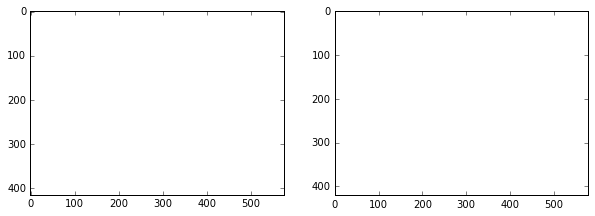

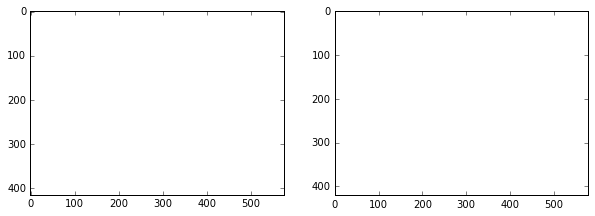

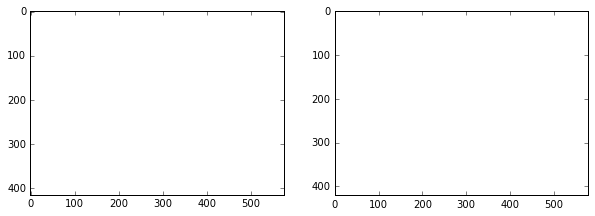

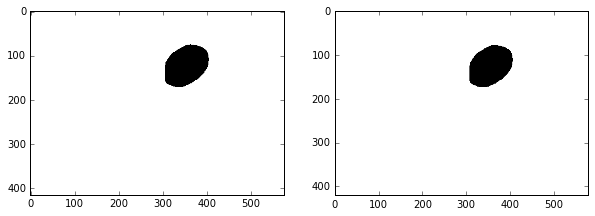

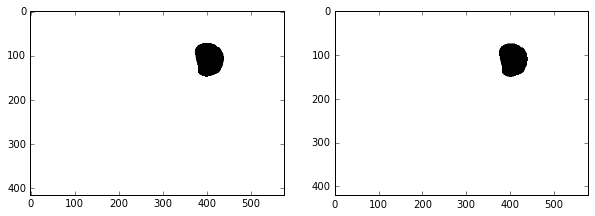

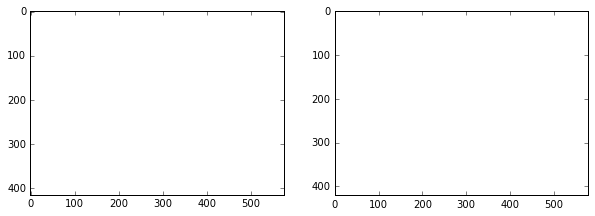

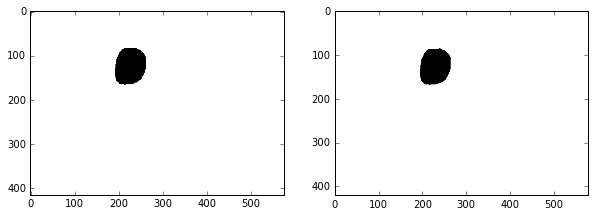

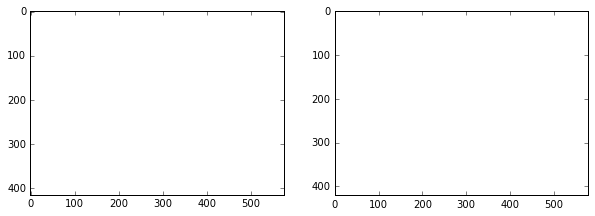

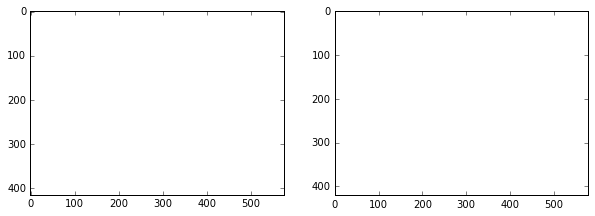

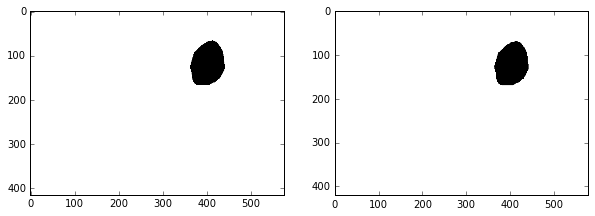

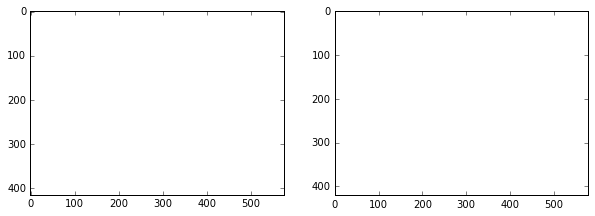

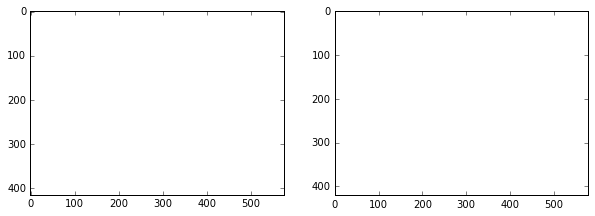

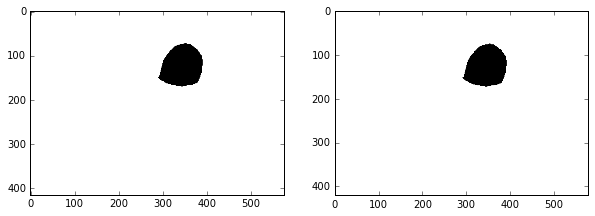

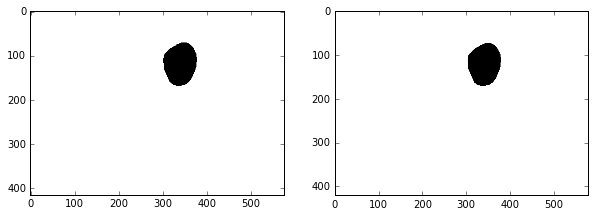

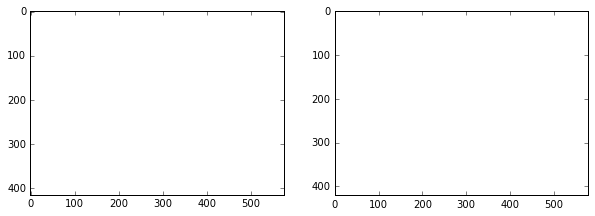

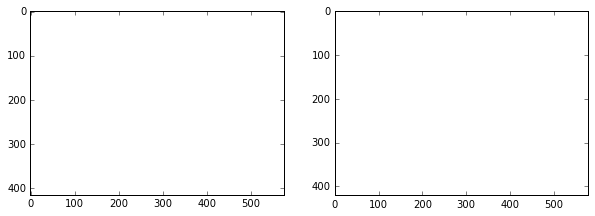

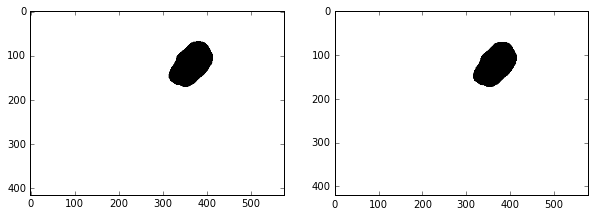

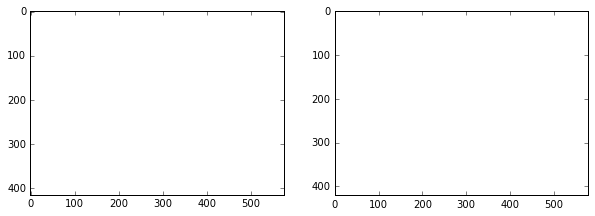

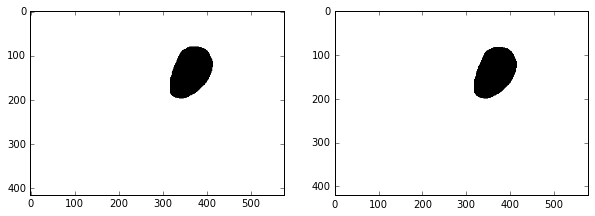

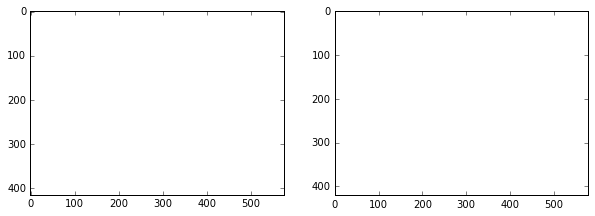

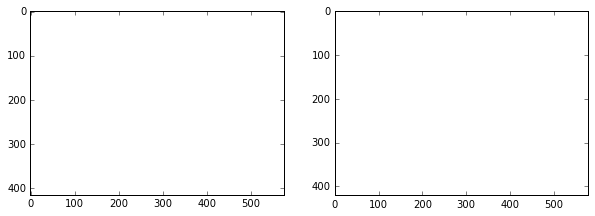

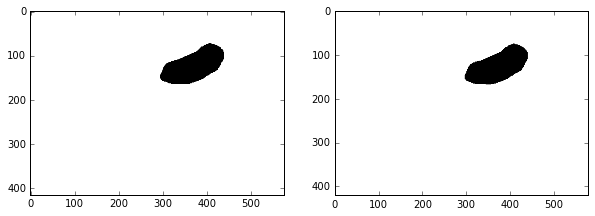

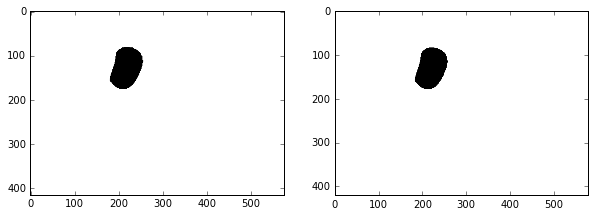

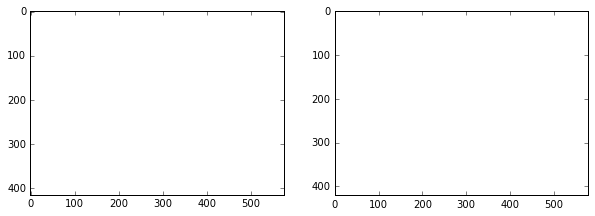

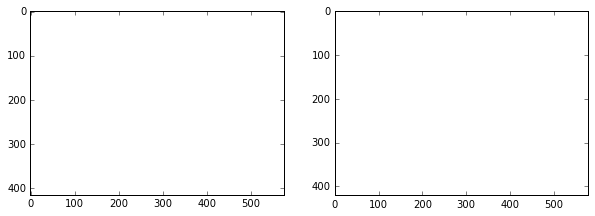

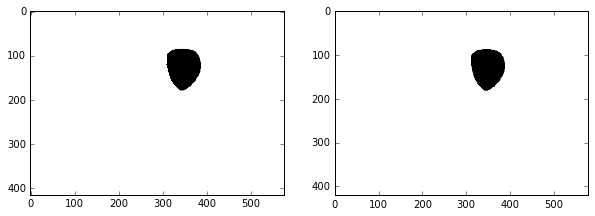

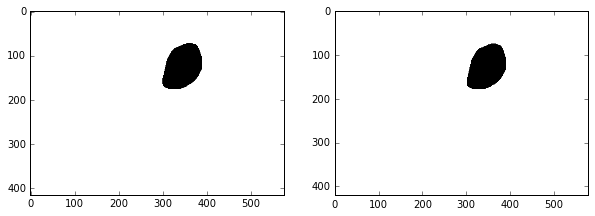

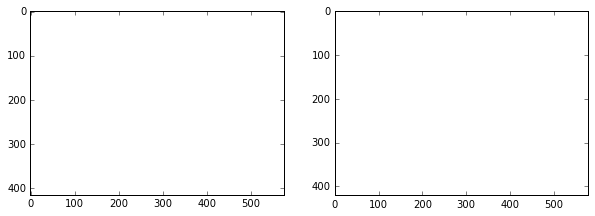

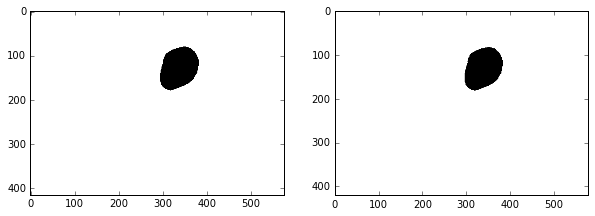

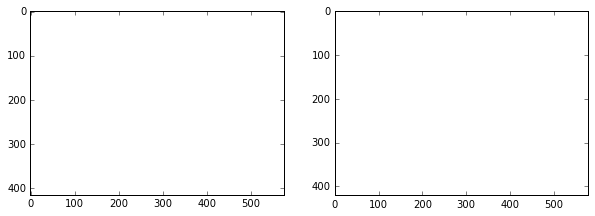

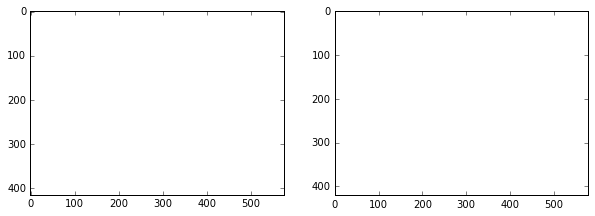

In [452]:
for i in range(11,42):
    compare_predicted_with_mask(i)

In [380]:
loaded_inference[0].shape

(1, 2, 4, 416, 576)

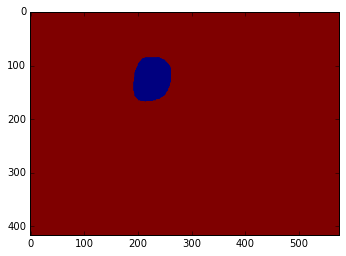

In [390]:
plt.imshow(loaded_inference[1][0,1,2,:,:])

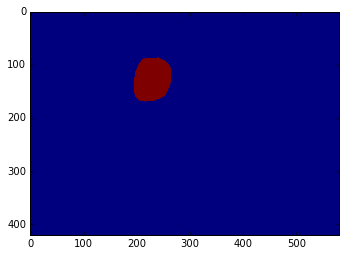

In [391]:
plt.imshow(load_mask(1,17))

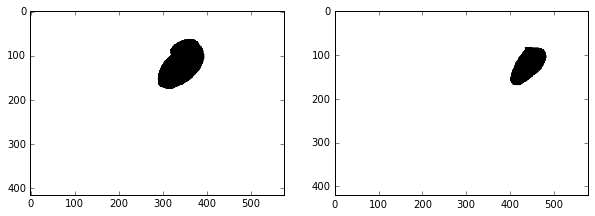

In [192]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(221)
ax1.imshow(np.logical_not(reordered[-1,1,:,:]).astype(bool),cmap='Greys')
ax2 = fig.add_subplot(222)
plt.imshow(load_mask(1,1),cmap="Greys")

In [170]:
#build_single(sess,bottleneck,training,'../bottleneck_files/')

In [11]:
#build_output_data(sess,[net.fc6,net.pool4],4,training,'../bottleneck_files/')

Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_1
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_2
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_3
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_4
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_5
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_6
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_7
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_8
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_9
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_10
Finished running forward passes
Output 

/home/chrisv/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_12
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_13
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_14
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_15
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_16
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_17
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_18
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_19
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_20
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_21
Finished running forward passe

In [2]:
### more predictions

In [52]:
second_batch = np.fromfile('/Users/gus/CDIPS/mask_debug/fc6pool4mask_batch_2',dtype=np.float32)

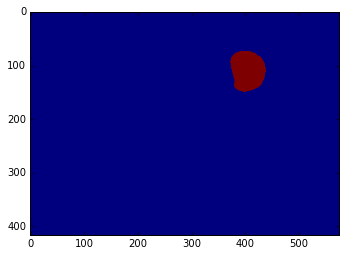

In [57]:
plt.imshow(second_batch[1*L-p:1*L].reshape(416,576,2)[:,:,0])

In [34]:
416*576

239616

In [35]:
p

479232

In [61]:
second_preds = np.load('/Users/gus/CDIPS/fcn_eval_log/predictions_chunk_2.npy')

In [63]:
second_preds.shape

(4, 2, 10, 416, 576)

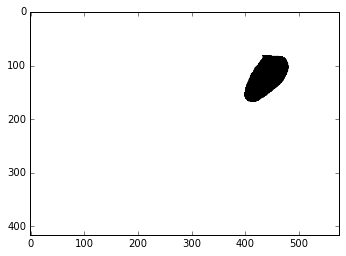

In [67]:
plt.imshow(~second_preds[0,1,0,:,:].astype(bool),cmap="Greys")